In [3]:
import ml_model_functions
import numpy as np
import importlib
from ml_model_functions import *

# Modul neu laden
importlib.reload(ml_model_functions)

<module 'ml_model_functions' from '/Users/tomhartmann/Desktop/studienarbeit-migrationsmodellierung/models/fdm/ml_model_functions.py'>

In [ ]:
# Simulationsparameter
T_C = 20  # Temperatur [°C]
M_r = 136  # Molekülmasse [g/mol]
T = 3600 * 24 * 10  # Gesamte Simulationszeit [s]
dt = 1000  # Zeitschrittgröße [s]
d_nx_ratio = 0.001 

d_last_values = np.linspace(0.02, 0.2, num = 10)

# Initialisiere ein Array für die Ergebnisse (2 Spalten: d_nx_ratio und Mass Error)
results_d_last = []

for i, d_last in enumerate(d_last_values):
    print(f"Simulating for d_last = {d_last}")

    # Definition der Schichten
    layers = [
        Layer(material='HDPE', d=0.2, nx=int(0.2 / d_nx_ratio), C_init=1000.0),
        Layer(material='LDPE', d=d_last, nx=int(d_last / d_nx_ratio), C_init=0.0),
        Layer(material='Kontaktphase', d=1.0, nx=int(1.0 / d_nx_ratio), C_init=0.0)
    ]

    # Berechnung der Diffusionskoeffizienten
    for layer in layers:
        layer.set_diffusion_coefficient(M_r, T_C)

    # Führe die Simulation durch
    C_values, C_init, total_masses, x, partitioning_checks = run_simulation(layers, T, dt)

    # Berechne den anfänglichen Fehler in der Gesamtmasse
    total_masses_init = np.trapz(C_init, x)
    
    # # Plot und Berechnung der Massenerhaltung
    # plot_mass_conservation(total_masses, total_masses_init, T, len(C_values), plot_interval=1)
    
    # Berechne die migrierte Masse über die Zeit
    migrated_mass, _ = calculate_migrated_mass_over_time(C_values, x, layers, dt, calc_interval=1)

    # Speichere das Ergebnis: Schichtdicke und migrierte Massen für alle Zeitpunkte
    results_d_last.append([d_last, migrated_mass])


In [17]:
# Konvertiere deine Liste in ein np.array und speichere die Daten
d_last_values = np.array([item[0] for item in results_d_last])  # Extrahiere d_last Werte
migrated_mass_values = np.array([item[1] for item in results_d_last], dtype=object)  # Extrahiere migrierte Massen

# Speichere beide Arrays als npz Datei
np.savez('/Users/tomhartmann/Desktop/studienarbeit-migrationsmodellierung/data/Fehlerbetrachtung/d_last_and_migrated_mass.npz', d_last_values=d_last_values, migrated_mass_values=migrated_mass_values)


In [18]:
# Lade die gespeicherten Daten
data = np.load('/Users/tomhartmann/Desktop/studienarbeit-migrationsmodellierung/data/Fehlerbetrachtung/d_last_and_migrated_mass.npz', allow_pickle=True)

# Extrahiere die d_last Werte und migrierten Massen
d_last_values = data['d_last_values']
migrated_mass_values = data['migrated_mass_values']


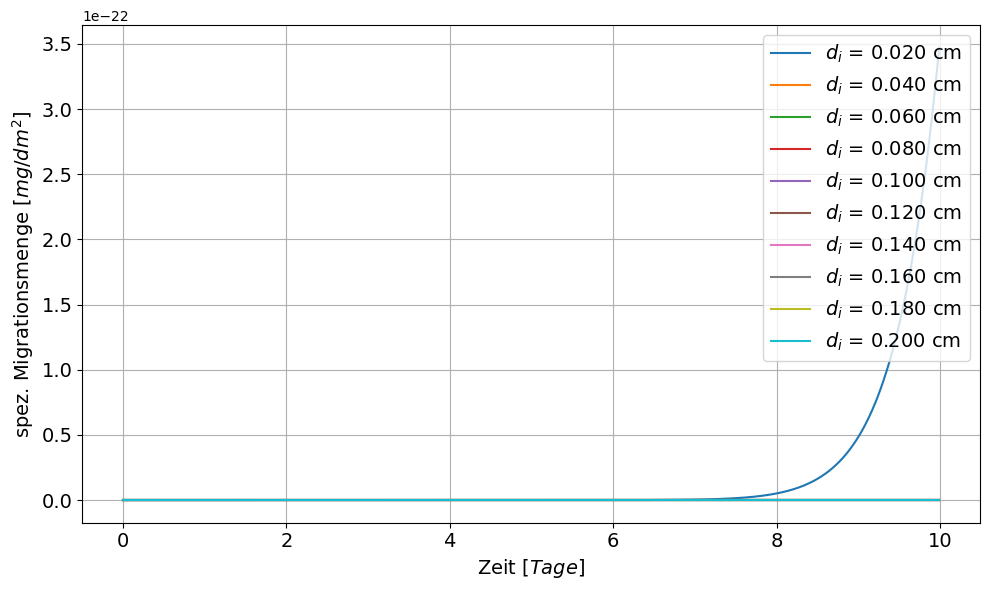

In [20]:
plt.figure(figsize=(10,6))
# Erstelle einen Plot für jeden d_last Wert
for i, d_last in enumerate(d_last_values):
    migrated_mass = migrated_mass_values[i]  # Migrierte Masse über die Zeit
    time_values = np.arange(len(migrated_mass)) * dt / (3600 * 24) 
    
    # Plot der Migrationskurve für diesen d_last-Wert
    plt.plot(time_values, migrated_mass, label=f'$d_i$ = {d_last:.3f} cm')

# Plot-Details festlegen
plt.xlabel('Zeit $[Tage]$', fontsize=14)
plt.ylabel('spez. Migrationsmenge $[mg/dm^2]$', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid(True)
plt.tight_layout()

# Plot speichern und anzeigen
plt.savefig('/Users/tomhartmann/Desktop/studienarbeit-migrationsmodellierung/data/Fehlerbetrachtung/migrationskurven_LDPE_schichtdicken.pdf')
plt.show()


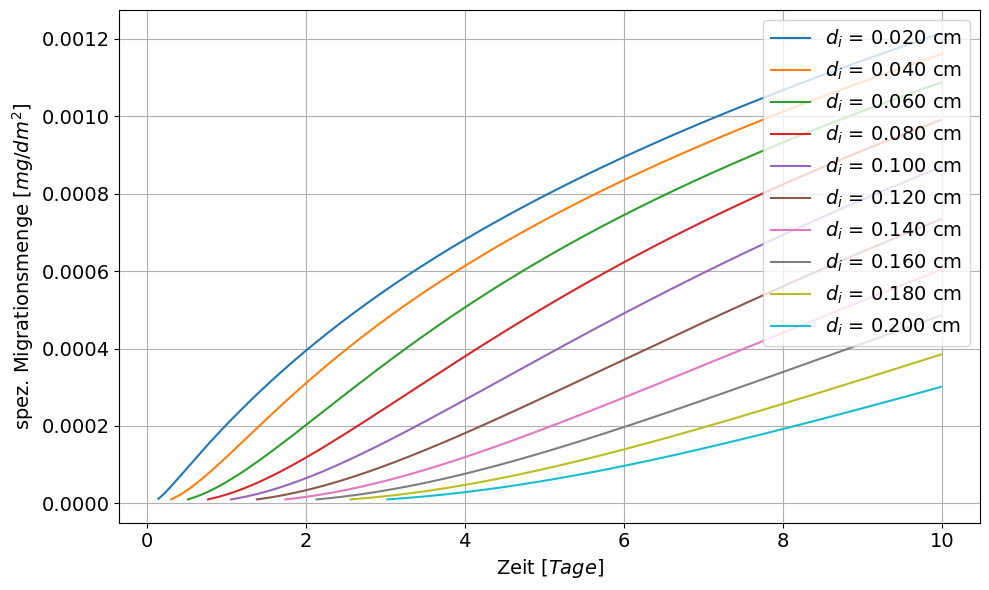

In [21]:
# Lade die gefilterten Daten
filtered_results = np.load('/Users/tomhartmann/Desktop/studienarbeit-migrationsmodellierung/data/Fehlerbetrachtung/filtered_migration_data_for_threshold.npy')

# Erstelle den Plot
plt.figure(figsize=(10, 6))

# Iteriere über die gefilterten Ergebnisse und plotte sie
for i, d_last in enumerate(np.unique(filtered_results[:, 0])):
    # Finde die Einträge für die aktuelle Schichtdicke
    mask = filtered_results[:, 0] == d_last
    times = filtered_results[mask][:, 1]  # Zeitpunkte in Tagen
    migrated_masses = filtered_results[mask][:, 2]  # Migrierte Massen
    
    # Plot der Migrationskurve für diesen d_last-Wert
    plt.plot(times, migrated_masses, label=f'$d_i$ = {d_last:.3f} cm')

# Plot-Details festlegen
plt.xlabel('Zeit $[Tage]$', fontsize=14)
plt.ylabel('spez. Migrationsmenge $[mg/dm^2]$', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.tight_layout()

# Plot speichern und anzeigen
plt.savefig('/Users/tomhartmann/Desktop/studienarbeit-migrationsmodellierung/data/Fehlerbetrachtung/filtered_migration_above_threshold.pdf')
plt.show()
